# Histopathology Cancer Classification Using Deep Learning

Lymph Node Metastases (LNMets) are common problems for patients with cancer. Patients whose cancer cells spread to the lymph nodes are at higher risk for death from cancer than those whose lamph nodes are free of cancer. More cancer cells in the lymph nodes means that cancer is more likely to spread to other places in the body. To identify the sentinel lymph nodes (lymph nodes containing metastasized cancer cells), the histopathologic scans of lymph node sections should be assessed by a pathologist. This is very time-consuming process and is prone to careless mistakes like missing the small metastases. Hence, deep learning algorithms can be used to automatically detect the metastase in lymph nodes and help a pathologist in this process. Developing a model for classifying the whole slide images of sentinel lymph node sections using deep learning algorithms can open the new routes for fast and more accurate identification of the metastase in lymph node sections. However, this is in aid of a pathologist and not a replacement for identifying the scans by an pathologist. 
 

The original source of the dataset is PatchCamelyon benchmark which is color images (96 x 96p with 3 channels) extracted from histopathologic scans of lymph node sections. It is available in github here:

https://github.com/basveeling/pcam

However, I used a subset of that which is available in Kaggle website through the link below:

https://www.kaggle.com/c/histopathologic-cancer-detection

As mentioned in the Kaggle page, the dataset is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates). The data set have 220,025 images. 130908 images are negative and 89117 images are positive (ratio of positive  to negative is 40 to 60). 


First, convolutional neural networks model was used to recognize visual patterns. The cnn model structure with adam optimizer contains 4 convolutional blocks that each includes 3 conv2D layers, a maxpool2D and a dropout layer. the size of filters that used in conv2d layers were 16, 32, 64 and 128. It was followed by a flatten, Dense, dropout and an output dense layer (having just one node).  In the second part of this notebook, I tried residual neuoral network (ResNet) to obtain the highest accuracy. As it defined in its wikipedia page, A residual neural network (ResNet) is an artificial neural network (ANN) of a kind that builds on constructs known from pyramidal cells in the cerebral cortex. Residual neural networks do this by utilizing skip connections, or shortcuts to jump over some layers. I used the ResNet50 from Keras models.  

In [1]:
#First I loaded and imported the required packages
import numpy as np
import pandas as pd
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
import os
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import ResNet50
from keras import optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, classification_report
from itertools import product
import cv2
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


Here are the available files from the Kaggle data. I used the images in 'images' folder and their corresponding labels in 'train_labels.csv' file. It includes 220025 images.

In [3]:
print(os.listdir('data'))

['images', 'sample_submission.csv', 'test', 'train_labels.csv']


I created a dataframe that includes all Train Image Labels and .tif to the IDs.

In [4]:
df = pd.read_csv('data/train_labels.csv',dtype=str)

In [5]:
df['id'] = df['id'] + '.tif'

In [6]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


The images are labeled 0 and 1, where 0 means there is no cancer cell and 1 shows it has cancer cells.

In [7]:
#total number of images with labels
df['label'].count()

220025

In [8]:
#total number of positive and negative cases
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

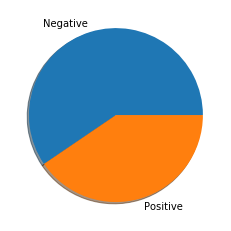

In [9]:
#The distribution is almost 60 to 40
plt.pie(df['label'].value_counts(), labels=['Negative', 'Positive'], shadow=True)
plt.show()

The 60% of the dataset is negative and around 40% is positive. 
It indicates that if all the images are assigned as the more populated class (negative), we get an accuracy of 60% (baseline classification).

The imbalance in dataset is negligible and it doesn't affect the performance of the model. So we can use the dataset as it is and no further processing like oversampling or undersampling is needed.

Here, 4 samples from negative and positive cases are shown:

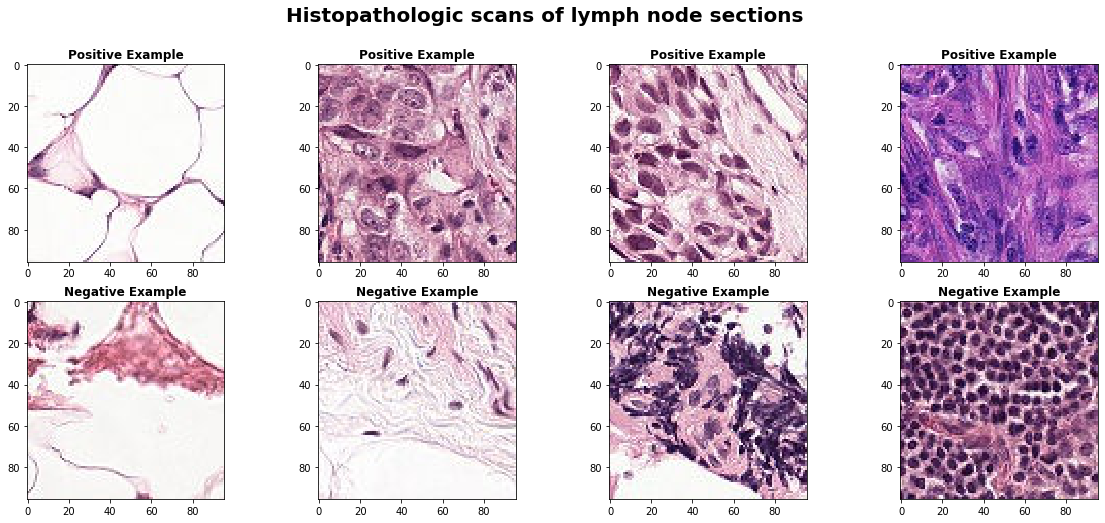

In [10]:
#displaying 4 positive and negative cases.
path = 'data/images/'
def readImage(path):
    # OpenCV reads the image (bgr format)
    bgr_img = cv2.imread(path)
    # flip it to rgb 
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img
positive_indices = list(np.where(df['label'] == '1')[0])
negative_indices = list(np.where(df['label'] == '0')[0])
rand_pos_inds = random.sample(positive_indices, 4)
rand_neg_inds = random.sample(negative_indices, 4)

fig, ax = plt.subplots(2,4, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20, fontweight='bold')

for i in range(0, 4):
    ax[0,i].imshow(readImage(path+df.iloc[rand_pos_inds[i],0]))
    ax[0,i].set_title("Positive Example", fontweight='bold')
    
    ax[1,i].imshow(readImage(path+df.iloc[rand_neg_inds[i],0]))
    ax[1,i].set_title("Negative Example", fontweight='bold')

The abnormal cancer cells can be identifyied by malignancy,  and irregular nuclear shape, nuclear enlargement, and staining shades. However, it is not even easy task for pathologists and , ofcourse, it is extremely difficult for untrained person. 

I created train, validation, and test datasets using train test split:

In [11]:
df_train_val, df_test = train_test_split(df, test_size=0.1, random_state=42)

In [12]:
df_train, df_val = train_test_split(df_train_val, test_size=0.1, random_state=42)

In [13]:
df_train['label'].count()

178219

In [14]:
df_train['label'].value_counts()

0    105997
1     72222
Name: label, dtype: int64

In [15]:
df_val['label'].count()

19803

In [16]:
df_val['label'].value_counts()

0    11793
1     8010
Name: label, dtype: int64

In [17]:
df_test['label'].count()

22003

In [18]:
df_test['label'].value_counts()

0    13118
1     8885
Name: label, dtype: int64

In [19]:
df_test.head()

,id,label
107796,d293308913e4a40cebb809d986aa9add65a76bfa.tif,0
11942,fcd55f03496afb4b11598d9c2231e86da318e723.tif,1
163858,5c983c8f14afeffdb098b9f3cbb68488a802b957.tif,0
184810,71bf03e8530348e57ec07d8ce2052f215390c997.tif,0
150958,1533406000e26663c5fadac3bcc3e38285a45bb3.tif,1


In [20]:
df_train.head()

,id,label
189844,118b8fce5663d15bb69310561cd7e371540682c2.tif,1
157456,f07176b1ba1ddb61003ad3761ee5a414b0ee3245.tif,1
158906,c29848e1e21719f8a6edc5bc1153b48a27d9ad13.tif,0
168577,ef6d294191adb3279672e923cd1b48de6870af2f.tif,0
147935,7b68f8af6438bc32d5de13cdf4378e0e817b826e.tif,0


There are couple of ways we can use to avoid overfitting like augmentation and regularization. In this notebook, I used early stoping in keras which is a regularization method.

# CNN Model

I used the following generators to feed the data into the CNN model for training, validation and testing.

In [21]:
train_batches_cnn = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=df_train,
                                                                                            directory='data/images/',
                                                                                            x_col='id',
                                                                                            y_col='label',
                                                                                            batch_size=10,
                                                                                            class_mode='binary',
                                                                                            target_size=(96,96))
val_batches_cnn = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=df_val,
                                                                                        directory='data/images/',
                                                                                        x_col='id',
                                                                                        y_col='label',
                                                                                        batch_size=10,
                                                                                        class_mode='binary',
                                                                                        target_size=(96,96)) 
test_batches_cnn = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=df_test,
                                                                                        directory='data/images/',
                                                                                        x_col='id',
                                                                                        y_col='label',
                                                                                        batch_size=10,
                                                                                        shuffle = False,
                                                                                        class_mode='binary',
                                                                                        target_size=(96,96)) 

Found 178219 validated image filenames belonging to 2 classes.
Found 19803 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.


In [22]:
train_batches_cnn.n

178219

In [23]:
train_batches_cnn.batch_size

10

# Defining the model: CNN model structure with adam optimizer:

In my first attempt, I created a simple model with 4 convolutional blocks that each block includes:

2 conv2D layers 

a batch normalization layer 

an activation layer

a maxpool2D 

a dropout layer


In [24]:
kernel_size = (3,3)
pool_size= (2,2)
n_filters_1 = 16
n_filters_2 = 32
n_filters_3 = 64
n_filters_4 = 128

dropout_conv = 0.3
dropout_dense = 0.5

model_cnn = Sequential()

model_cnn.add(Conv2D(n_filters_1, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model_cnn.add(Conv2D(n_filters_1, kernel_size, use_bias=False))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPool2D(pool_size = pool_size)) 
model_cnn.add(Dropout(dropout_conv))

model_cnn.add(Conv2D(n_filters_2, kernel_size, use_bias=False))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(Conv2D(n_filters_2, kernel_size, use_bias=False))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPool2D(pool_size = pool_size))
model_cnn.add(Dropout(dropout_conv))

model_cnn.add(Conv2D(n_filters_3, kernel_size, use_bias=False))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(Conv2D(n_filters_3, kernel_size, use_bias=False))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPool2D(pool_size = pool_size))
model_cnn.add(Dropout(dropout_conv))

model_cnn.add(Conv2D(n_filters_4, kernel_size, use_bias=False))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(Conv2D(n_filters_4, kernel_size, use_bias=False))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPool2D(pool_size = pool_size))
model_cnn.add(Dropout(dropout_conv))

model_cnn.add(Flatten())
model_cnn.add(Dense(256, use_bias=False))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(Dropout(dropout_dense))
model_cnn.add(Dense(1, activation = "sigmoid"))


model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 16)        2304      
_________________________________________________________________
batch_normalization (BatchNo (None, 92, 92, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 92, 92, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        4

In [25]:
# Compile the model
model_cnn.compile('adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Training the model 

To monitor the performance of the model, I used the model checkpoints callbacks, early stopping, and reduce learning rate on plateau in keras.

Early stopping can deal with one of the most important issues for the training of deep learning models which is the choice of number of epochs.

Too many or too few epochs leads to overfitting and underfitting respectively. As mentioned above, I used early stopping method to stop the training when the validation scores stops improving.

In [26]:
mc_cnn = ModelCheckpoint(filepath='model_cnn.h5',
                                         monitor = 'val_acc',
                                         verbose = 1, 
                                         save_best_only = True,
                                         mode = 'max')

es = EarlyStopping(
                    monitor = 'val_loss',
                    min_delta=0.01,
                    patience = 5,
                    verbose = 1,
                    mode = 'min')


rlrop = ReduceLROnPlateau(monitor='val_loss',
                           factor=0.1,
                          patience=3,
                          verbose=1,
                          mode='auto',
                          min_lr=10e-7)

cb_list_cnn = [mc_cnn,es, rlrop]


In [27]:
history_cnn = model_cnn.fit(train_batches_cnn,
                              steps_per_epoch = np.ceil(len(df_train) / 10),
                              validation_data = val_batches_cnn,
                              validation_steps = np.ceil(len(df_val) / 10),
                              epochs = 20,
                             callbacks = cb_list_cnn)

Epoch 1/20
17822/17822 [==============================] - 123s 7ms/step - loss: 0.4306 - accuracy: 0.8106 - val_loss: 0.3502 - val_accuracy: 0.8406
Epoch 2/20
17822/17822 [==============================] - 129s 7ms/step - loss: 0.3545 - accuracy: 0.8536 - val_loss: 0.3419 - val_accuracy: 0.8539
Epoch 3/20
17822/17822 [==============================] - 131s 7ms/step - loss: 0.3232 - accuracy: 0.8691 - val_loss: 0.3650 - val_accuracy: 0.8306
Epoch 4/20
17822/17822 [==============================] - 129s 7ms/step - loss: 0.3018 - accuracy: 0.8796 - val_loss: 0.2919 - val_accuracy: 0.8849
Epoch 5/20
17822/17822 [==============================] - 130s 7ms/step - loss: 0.2886 - accuracy: 0.8853 - val_loss: 0.2880 - val_accuracy: 0.8862
Epoch 6/20
17822/17822 [==============================] - 131s 7ms/step - loss: 0.2767 - accuracy: 0.8913 - val_loss: 0.2544 - val_accuracy: 0.8955
Epoch 7/20
17822/17822 [==============================] - 132s 7ms/step - loss: 0.2697 - accuracy: 0.8946 - val_

The model was trained successfully. we plot some training graphs to see how our accuracies, and losses varied over epochs.

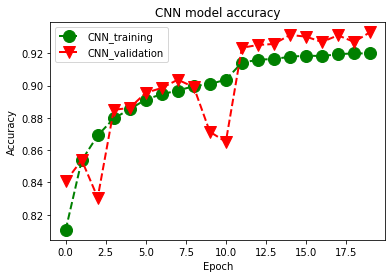

In [28]:
plt.plot(history_cnn.history['accuracy'], color='green', marker='o', linestyle='dashed',
         linewidth=2, markersize=12)
plt.plot(history_cnn.history['val_accuracy'], color='red', marker='v', linestyle='dashed',
         linewidth=2, markersize=12)
plt.title('CNN model accuracy')
plt.legend(['CNN_training','CNN_validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

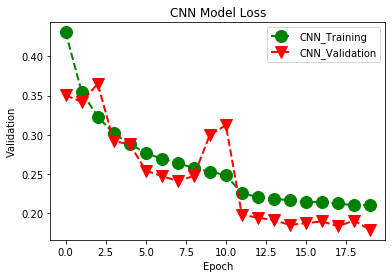

In [29]:
plt.plot(history_cnn.history['loss'],color='green', marker='o', linestyle='dashed',
         linewidth=2, markersize=12)
plt.plot(history_cnn.history['val_loss'],color='red', marker='v', linestyle='dashed',
         linewidth=2, markersize=12)
plt.title('CNN Model Loss')
plt.legend(['CNN_Training','CNN_Validation'], loc='best')
plt.ylabel('Validation')
plt.xlabel('Epoch')
plt.show()

In order to evaluate our model, the prediction was done over the test dataset and confusion matrix and classification report was created.

In [30]:
preds_cnn = model_cnn.predict(test_batches_cnn,steps = len(test_batches_cnn), verbose=1)

2201/2201 [==============================] - 21s 10ms/step


In [31]:
test_batches_cnn.class_indices

{'0': 0, '1': 1}

In [32]:
classes_cnn = ['negative', 'positive']

In [33]:
len(preds_cnn)

22003

In [34]:
len(test_batches_cnn)

2201

In [35]:
np.round(preds_cnn)

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [37]:
np.argmax(preds_cnn)

15330

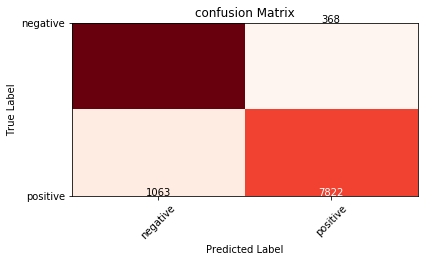

In [40]:
plt.imshow(cm, interpolation='nearest',cmap = plt.cm.Reds)
plt.title('confusion Matrix')

tick_marks = np.arange(len(classes_cnn))
plt.xticks(tick_marks, classes_cnn, rotation = 45)
plt.yticks(tick_marks, classes_cnn)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
fmt = 'd'
thresh = cm.max() / 2
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
             color = "white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

There are four ways to check if the predictions are right or wrong:

TN / True Negative: the case was negative and predicted negative

TP / True Positive: the case was positive and predicted positive

FN / False Negative: the case was positive but predicted negative

FP / False Positive: the case was negative but predicted positive

In [36]:
cm = confusion_matrix(y_true = test_batches_cnn.classes, y_pred=np.round(preds_cnn))
cr = classification_report(y_true = test_batches_cnn.classes, y_pred=np.round(preds_cnn), target_names = classes_cnn)
print(cm)
print(cr)

[[12750   368]
 [ 1063  7822]]
              precision    recall  f1-score   support

    negative       0.92      0.97      0.95     13118
    positive       0.96      0.88      0.92      8885

    accuracy                           0.93     22003
   macro avg       0.94      0.93      0.93     22003
weighted avg       0.94      0.93      0.93     22003



The classification report displays the precision, recall, F1, and support scores for the model.

Accuracy : fraction of predictions our model got right. 

Precision: Accuracy of positive predictions.

Precision = TP/(TP + FP)

Recall: Fraction of positives that were correctly identified.

Recall = TP/(TP+FN)

The f1-score gives the harmonic mean of precision and recall. 

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

The support is the number of samples of the true response that lie in that class.

The most important metric is recall because we want the minimum false negative in cancer detection. the recall score for CNN model is 0.88.

# Second Part: ResNet50 model

In the second part of this notebook, I tried to improve the accuracy by using ResNet50 model from keras. It jump over some layers using the Skip Connections (known also as shortcuts) and has lower complexity and easier to handle for large datasets. Here, I did not use the pretrained values and model was trained with our training dataset. 

Similar to CNN model, the performance of the model was monitored using the model checkpoints callbacks. the overfitting issue was also addressed using early stopping in keras.


In [41]:
train_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=df_train,
                                                                                            directory='data/images/',
                                                                                            x_col='id',
                                                                                            y_col='label',
                                                                                            batch_size=10,
                                                                                            target_size=(96,96))
val_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=df_val,
                                                                                        directory='data/images/',
                                                                                        x_col='id',
                                                                                        y_col='label',
                                                                                        batch_size=10,
                                                                                        target_size=(96,96)) 
test_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=df_test,
                                                                                        directory='data/images/',
                                                                                        x_col='id',
                                                                                        y_col='label',
                                                                                        batch_size=10,
                                                                                        shuffle = False,
                                                                                        target_size=(96,96)) 

Found 178219 validated image filenames belonging to 2 classes.
Found 19803 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.


In [42]:
model = ResNet50(weights =None, input_shape = (96, 96, 3), classes = 2)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [43]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [44]:
mc = ModelCheckpoint(filepath='model.h5',
                                         monitor = 'val_acc',
                                         verbose = 1, 
                                         save_best_only = True,
                                         mode = 'max')

es = EarlyStopping(
                    monitor = 'val_loss',
                    min_delta=0.01,
                    patience = 5,
                    verbose = 1,
                    mode = 'min')


rlrop = ReduceLROnPlateau(monitor='val_loss',
                           factor=0.5,
                          patience=3,
                          verbose=1,
                          mode='min',
                          min_lr=10e-7)

cb_list = [mc,es, rlrop]


In [45]:
history = model.fit(train_batches,
                              steps_per_epoch = np.ceil(len(df_train) / 10),
                              validation_data = val_batches,
                              validation_steps = np.ceil(len(df_val) / 10),
                              epochs = 20,
                                callbacks = cb_list)

Epoch 1/20
17822/17822 [==============================] - 591s 33ms/step - loss: 0.4595 - accuracy: 0.8003 - val_loss: 1.0402 - val_accuracy: 0.6260
Epoch 2/20
17822/17822 [==============================] - 593s 33ms/step - loss: 0.3363 - accuracy: 0.8579 - val_loss: 0.3059 - val_accuracy: 0.8687
Epoch 3/20
17822/17822 [==============================] - 590s 33ms/step - loss: 0.2764 - accuracy: 0.8874 - val_loss: 0.3988 - val_accuracy: 0.8342
Epoch 4/20
17822/17822 [==============================] - 590s 33ms/step - loss: 0.2487 - accuracy: 0.9013 - val_loss: 0.7474 - val_accuracy: 0.7652
Epoch 5/20
17822/17822 [==============================] - 601s 34ms/step - loss: 0.2285 - accuracy: 0.9101 - val_loss: 0.1915 - val_accuracy: 0.9245
Epoch 6/20
17822/17822 [==============================] - 603s 34ms/step - loss: 0.2139 - accuracy: 0.9164 - val_loss: 0.2035 - val_accuracy: 0.9205
Epoch 7/20
17822/17822 [==============================] - 605s 34ms/step - loss: 0.2019 - accuracy: 0.9224

After successfult training the model, graphs are plotted to see how our accuracies, auc and losses varied over epochs.

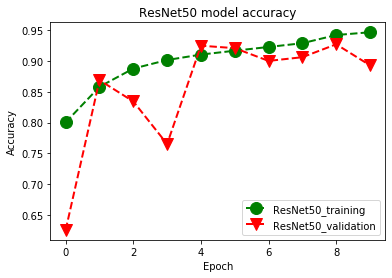

In [48]:
plt.plot(history.history['accuracy'], color='green', marker='o', linestyle='dashed',
         linewidth=2, markersize=12)
plt.plot(history.history['val_accuracy'], color='red', marker='v', linestyle='dashed',
         linewidth=2, markersize=12)
plt.title('ResNet50 model accuracy')
plt.legend(['ResNet50_training','ResNet50_validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

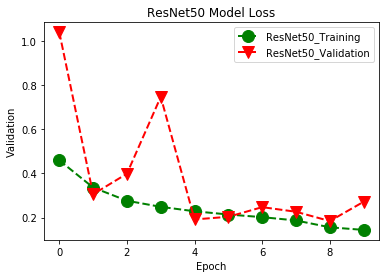

In [49]:
plt.plot(history.history['loss'],color='green', marker='o', linestyle='dashed',
         linewidth=2, markersize=12)
plt.plot(history.history['val_loss'],color='red', marker='v', linestyle='dashed',
         linewidth=2, markersize=12)
plt.title('ResNet50 Model Loss')
plt.legend(['ResNet50_Training','ResNet50_Validation'], loc='best')
plt.ylabel('Validation')
plt.xlabel('Epoch')
plt.show()

To evaluate our ResNet50 model, the prediction was done over the test dataset. The confusion matrix and classification report was also created.

In [50]:
preds_resnet = model.predict(test_batches,steps = len(test_batches), verbose=1)

2201/2201 [==============================] - 19s 9ms/step


In [51]:
preds_resnet

array([[0.99821895, 0.00178103],
       [0.00282063, 0.9971794 ],
       [0.99589086, 0.00410909],
       ...,
       [0.970618  , 0.02938194],
       [0.0055036 , 0.9944964 ],
       [0.40226632, 0.59773374]], dtype=float32)

In [52]:
np.round(preds_resnet)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [53]:
np.argmax(preds_resnet,axis=-1)

array([0, 1, 0, ..., 0, 1, 1], dtype=int64)

In [54]:
test_batches.class_indices

{'0': 0, '1': 1}

In [55]:
classes = ['negative', 'positive']

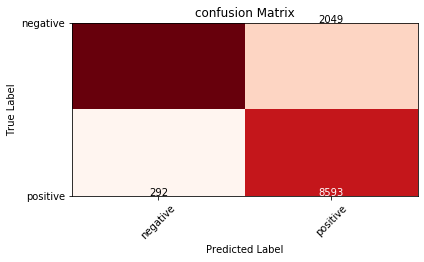

In [57]:
plt.imshow(cm, interpolation='nearest',cmap = plt.cm.Reds)
plt.title('confusion Matrix')

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
fmt = 'd'
thresh = cm.max() / 2
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
             color = "white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

In [56]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred=np.argmax(preds_resnet,axis=1))
cr = classification_report(y_true = test_batches.classes, y_pred=np.argmax(preds_resnet,axis=1), target_names = classes)
print(cm)
print(cr)

[[11069  2049]
 [  292  8593]]
              precision    recall  f1-score   support

    negative       0.97      0.84      0.90     13118
    positive       0.81      0.97      0.88      8885

    accuracy                           0.89     22003
   macro avg       0.89      0.91      0.89     22003
weighted avg       0.91      0.89      0.89     22003



As mentioned above, the most important metric is recall because we want the minimum false negative in cancer detection. the recall score for ResNet50 model is 0.97.

# Conclusion

To identify the metastasized cancer cells, the histopathologic scans should be assessed by a pathologist which is very time-consuming process and is prone to mistakes. Here, it is demonstrated that deep learning algorithms can be used to automatically detect the metastase in lymph nodes.This project can help pathologist with this error prone process. 

Here, the cancer cells were predicted using the dataset containing images of sentinel lymph node sections. To handle overfitting issue, I used early stopping in keras. In my first attempt, I used a cnn structure with adam optimizer as a model. It contained 4 sections that each includes 3 conv2D layers, maxpool2D and dropout layer. the size of filters that used in conv2d layers were 16, 32, 64 and 128. These are followed by a flatten, Dense, dropout and an output dense layer (having just one node).  To monitor the performance of the model, I used the model checkpoints callbacks, early stopping, and reduce learning rate on plateau in keras. The accuracy for test dataset was 0.93 and precision  and  recall were 0.96 and 0.88 respectively (f1 score= 0.92).

To achieve even better results, I tried  a residual neural network (ResNet). ResNet jumps over some layers using the Skip Connections (known also as shortcuts) and has lower complexity and easier to handle for large datasets. When ResNet50 from Keras was used, the obtained accuracy was 0.89 and precision  and  recall were 0.81 and 0.97 respectively (f1 score= 0.88).
With comparing the results obtained from both models, ResNet50 showed best performance for classification and identifying cancer cells in images. It shows very high recall which is the most important metric in cancer detection classifier.